  # Steigende Temperaturen in Berlin Tegel

  Die in diesem Notebook genutzten Daten stammen vom [Deutschen Wetterdienst (DWD)](https://www.dwd.de/)
  und werden über das [Climate Data Center (CDC)](https://www.dwd.de/DE/klimaumwelt/cdc/cdc_node.html) zur Verfügung gestellt.
  Konkret werden die
  [historischen](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_00430_19630101_20181231_hist.zip)
  und
  [aktuellen](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/tageswerte_KL_00430_akt.zip)
  täglichen Wetterdaten der DWD Messstation 430 in Berlin Tegel seit 1.1.1963 verwendet.

In [1]:
from IPython import get_ipython

In [2]:
# ms-python.python added
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks'))
    print(os.getcwd())
except:
    pass

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(rc={'figure.figsize':(20,10)})

data_files = [
    '../data/historisch/produkt_klima_tag_19630101_20181231_00430.txt',
    # '../data/aktuell/produkt_klima_tag_20180215_20190818_00430.txt'
]
df = pd.concat((pd.read_csv(f, 
                            sep=';',
                            header=None,
                            skiprows=1,
                            names=['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK', 'RSKF', 'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK', 'eor'],
                            usecols=['MESS_DATUM', 'RSK', 'TMK'],
                            na_values=['-999'],
                            parse_dates=['MESS_DATUM'],
                            ) for f in data_files), ignore_index=True)
df.index = df['MESS_DATUM']
df = df.drop(columns=['MESS_DATUM'])

In [3]:
def add_source(_ax):
    """Hilfsfunktion um Quellenangabe einem Plot hinzuzufügen"""
    _ax.text(1, 1, 'Quelle: Deutscher Wetterdienst (DWD)', ha='right', va='top', transform=_ax.transAxes)

## Tägliche Regenmenge (RSK) und Durchschnittstemperatur (TMK)

Die Datensammlung vom DWD umfasst eine Vielzahl von Messwerten wie Sonnenscheindauer,
relative Luftfeuchte, max. Windgeschwindigkeit, etc.

Ich picke mir lediglich zwei Werte raus:

- tägliche Regenmenge (RSK) - nehmen die Niederschläge ab und wird es immer trockener?
- tägliche Durchschnittstemperatur (TMK) - steigt die Temperatur?

Beide Werte stehen für alle Tage seit dem 1.1.1963 zur Verfügung.

In [4]:
df.head(5)

,RSK,TMK
MESS_DATUM,,
1963-01-01,0.0,-12.4
1963-01-02,0.0,-10.2
1963-01-03,0.0,-7.2
1963-01-04,1.3,-2.6
1963-01-05,0.0,1.7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20454 entries, 1963-01-01 to 2018-12-31
Data columns (total 2 columns):
RSK    20453 non-null float64
TMK    20454 non-null float64
dtypes: float64(2)
memory usage: 479.4 KB


In [6]:
df.describe()

,RSK,TMK
count,20453.000000,20454.000000
mean,1.503432,9.851545
std,3.975919,7.914333
min,0.000000,-18.100000
25%,0.000000,3.900000
50%,0.000000,10.000000
75%,1.300000,16.000000
max,196.900000,30.800000


Man erkennt an der Standardabweichung im Vergleich zu den Mittelwerten,
dass die Tageswerte für Temperatur und Niederschlag wenig hilfreich sind,
da die Messwerte stark schwanken (sie sind saisonal - Jahreszeiten).

Dies lässt sich für am Beispiel der Temperaturwerte in einem Boxplot visualisieren.

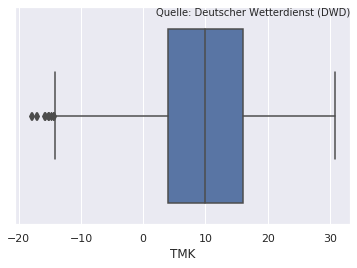

In [7]:
add_source(sns.boxplot(x=df['TMK']))

## Analyse Tagesmittel der Temperatur

Im Fall der Tagestemperaturwerte (TMK) ist es daher sinnvoller, einen jährlichen Durchschnitt zu bilden. Dadurch spielen Jahreszeiten keine Rolle mehr.

In [8]:
temp_df = df[['TMK']].resample('Y').mean()
temp_df.head(5)

,TMK
MESS_DATUM,
1963-12-31,8.266575
1964-12-31,8.927322
1965-12-31,8.337260
1966-12-31,9.263562
1967-12-31,10.159452


In [9]:
temp_df.describe()

,TMK
count,56.000000
mean,9.851656
std,0.919631
min,8.096448
25%,9.098838
50%,10.023410
75%,10.480392
max,11.595890


In [10]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 1963-12-31 to 2018-12-31
Freq: A-DEC
Data columns (total 1 columns):
TMK    56 non-null float64
dtypes: float64(1)
memory usage: 896.0 bytes


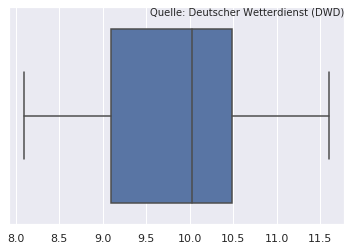

In [11]:
add_source(sns.boxplot(x=temp_df))

Dieses Histogramm sieht einer Käsekurve (Normalverteilung) ziemlich ähnlich.

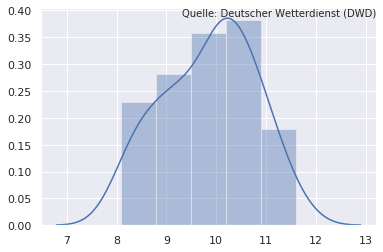

In [12]:
add_source(sns.distplot(temp_df))

Mit dem Shapiro Test kann man prüfen, ob eine Wertemenge normalverteilt ist.

In [13]:
stat, p = shapiro(temp_df['TMK'])
alpha = 0.05
if p > alpha:
    print('Die jährliche Durschnittstemperatur ist wahrscheinlich normalverteilt.')
else:
    print('Die jährliche Durchschnittstemperatur ist nicht normalverteilt.')

Die jährliche Durschnittstemperatur ist wahrscheinlich normalverteilt.


Auch wenn die durchschnittliche Jahrestemperatur stark schwankt, scheint es zumindest optisch einen klaren steigenden Trend zu geben.

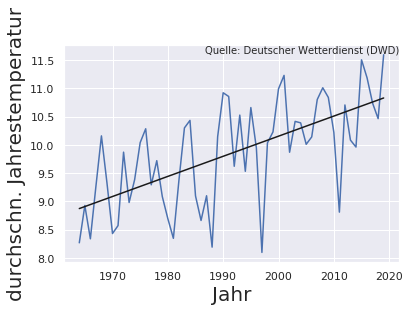

In [14]:
temp = sns.lineplot(data=temp_df, legend=False)
temp.set_xlabel('Jahr', fontsize=20)
temp.set_ylabel('durchschn. Jahrestemperatur', fontsize=20)
add_source(temp)

x = np.arange(temp_df['TMK'].size)
fit = np.polyfit(x, temp_df['TMK'], 1)
fit_fn = np.poly1d(fit)

temp.plot(temp_df.index, fit_fn(x), 'k-')

Bei steigenden Temperaturen über die Jahre würde man erwarten, dass die Durschnittstemperatur der letzten Jahre über der Durschnittstemperatur der Anfangsjahre liegt.

Deshalb unterteile ich die gesamte Messreihe in zwei gleichgroße Blöcke X1 und X2 und ermittel für jeden Block Durschnitt und Varianz.

Achtung: Ab hier nutze ich logarithmisch vereinheitlichte Messwerte.

In [15]:
tmk_log = np.log(temp_df['TMK'].values)
tmk_split = int(len(tmk_log) / 2)

X1 = tmk_log[:tmk_split]
X2 = tmk_log[tmk_split:]

mean1 = X1.mean()
mean2 = X2.mean()

var1 = X1.var()
var2 = X2.var()

print('mean1={}, var1={}'.format(mean1, var1))
print('mean2={}, var2={}'.format(mean2, var2))

mean1=2.2328857443616745, var1=0.006938846110188799
mean2=2.3336491381848457, var2=0.005676896339597946


Die Werte sehen sehr ähnlich aus, auch wenn die zweite Hälfte der Werte eine leicht höhere Durchschnittstemperatur hat.

Es gibt verschiedene statistische Tests, um zu prüfen, ob eine Zeitreihe stationär ist oder ob sie einem Trend folgt.

Zunächst führe ich den Augmented Dickey-Fuller Test durch. Die Null-Hypothese dieses Tests ist, dass die Zeitreihe nicht stationär ist, sie also einem Trend folgt.

In [16]:
adfuller_alpha = 0.05

adf_result = adfuller(tmk_log)
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

if adf_p_value < adfuller_alpha:
    print('H0 abgelehnt: Zeitreihe anscheinend (alpha={}) stationär.'.format(adfuller_alpha))
else:
    print('H0 bestätigt: Zeitreihe anscheinend (alpha={}) nicht stationär (folgt einem Trend).'.format(adfuller_alpha))

print('ADF Statistik: {:.3f}'.format(adf_statistic))
print('p-value: {:3f}'.format(adf_p_value))
print('Critical Values:')
for key, value in adf_result[4].items():
    print('{}: {:.3f}'.format(key, value))

H0 abgelehnt: Zeitreihe anscheinend (alpha=0.05) stationär.
ADF Statistik: -4.314
p-value: 0.000421
Critical Values:
1%: -3.555
5%: -2.916
10%: -2.596


Der Augmented Dickey-Fuller Test führt zu einer klaren Ablehnung der These, dass die Zeitreihe einem Trend folgt.

Der KPSS Test ist ebenfalls anwendbar. Im Gegensatz zum vorherigen Test prüft er, ob eine Zeitreihe stationär ist, sie also keinem Trend folgt.

In [17]:
kpss_alpha = 0.05

kpss_result = kpss(tmk_log, lags='legacy')

kpss_statistic = kpss_result[0]
kpss_p_value = kpss_result[1]
kpss_critical_values = kpss_result[3]

if kpss_p_value < kpss_alpha:
    print('H0 abgelehnt: Zeitreihe anscheinend (alpha={}) nicht stationär (folgt einem Trend)'.format(kpss_alpha))
else:
    print('H0 bestätigt: Zeitreihe anscheinend (alpha={}) stationär.'.format(kpss_alpha))

print('KPSS Statistik: {:.3f}'.format(kpss_statistic))
print('p-value: {:3f}'.format(kpss_p_value))
for key, value in kpss_critical_values.items():
    print('{}: {:.3f}'.format(key, value))

H0 abgelehnt: Zeitreihe anscheinend (alpha=0.05) nicht stationär (folgt einem Trend)
KPSS Statistik: 0.593
p-value: 0.023313
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


Der KPSS Test lehnt bei einem Konfidenzniveau von 95% (alpha=0.05) ab, dass die Zeitreihe keinem Trend folgt, sie also stationär ist. Allerdings ist es nur eine schwache Ablehnung. Schon bei Anhebung des Konfidenzniveaus auf 97,5% kommt der Test zum entgegengesetzen Ergebnis.

## Interpretation Temperatur Zeitreihe

Und nun? Der KPSS Test bestätigt (gerade so), dass es wohl einen Trend in den Temperaturwerten gibt, während der Augmented Dickey-Fuller Test dies stark verneint. Das Diagramm weiter oben hingegen zeigt einen klaren steigenden Trend bei den durchschnittlichen Jahrestemperaturen.

So einfach ist die Sache also nicht. Wenn ich im Netz nach ähnlichen Analysen suche, dann spielen die Tagestemperaturen keine Rolle. Genutzt wird stattdessen die Temperatur der Böden, denn diese sind letztendlich entscheidend, ob die Eismassen und Permafrostböden schmelzen. Solche Messwerte liegen mir aber nicht vor.

Die Ergebnisse der beiden Zeitreihen-Tests (Augmented Dickey-Fuller Test und KPSS) sind besonders kritisch zu sehen, da unklar ist, welchen Trend (oder eben gerade nicht) die Tests erkennen? Hinzu kommt, dass ich mit gerade mal gut 50 Messwerten über wenig Futter für die Tests verfüge.

## Zeitreihe jährliche Regenmenge (RSK)

Bei den Regenwerten (RSK) ist die jährliche Regenmenge interessanter als die täglichen Einzelwerte.

In [18]:
regen_df = df[['RSK']].resample('Y').sum()
regen_df.head(5)

,RSK
MESS_DATUM,
1963-12-31,464.1
1964-12-31,482.2
1965-12-31,630.6
1966-12-31,752.3
1967-12-31,634.3


In [19]:
regen_df.describe()

,RSK
count,56.000000
mean,549.101786
std,104.560831
min,351.200000
25%,464.075000
50%,545.650000
75%,617.450000
max,858.200000


In [20]:
regen_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 1963-12-31 to 2018-12-31
Freq: A-DEC
Data columns (total 1 columns):
RSK    56 non-null float64
dtypes: float64(1)
memory usage: 896.0 bytes


  Das folgende Histogramm deutet daraufhin, dass die jährliche Regenmenge normalverteilt ist.

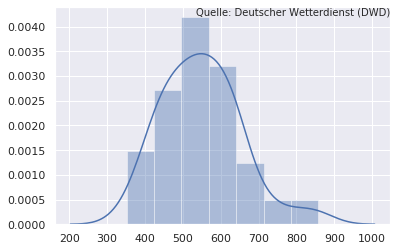

In [21]:
add_source(sns.distplot(regen_df))

Ich nutze den Shapiro-Wilk Test, um die jährliche Regenmenge auf Normalverteilung zu testen.

In [22]:
stat, p = shapiro(regen_df['RSK'])
alpha = 0.05
if p > alpha:
    print('Die jährliche Regenmenge ist wahrscheinlich normalverteilt.')
else:
    print('Die jährliche Regenmenge ist nicht normalverteilt.')

Die jährliche Regenmenge ist wahrscheinlich normalverteilt.


Auch in folgendem Diagramm kann ich keine steigende oder sinkende Regenmenge ablesen.

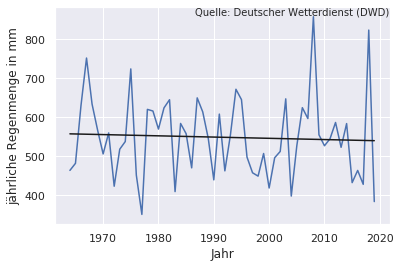

In [23]:
regen = sns.lineplot(data=regen_df, legend=False)
regen.set_xlabel('Jahr')
regen.set_ylabel('jährliche Regenmenge in mm')
add_source(regen)

x = np.arange(regen_df['RSK'].size)
fit = np.polyfit(x, regen_df['RSK'], 1)
fit_fn = np.poly1d(fit)
regen.plot(regen_df.index, fit_fn(x), 'k-')

## Fazit

Wie bereits weiter oben diskutiert, kann ich mit den vorliegenden Messwerten dem Klimawandel nicht auf die Schliche kommen, auch wenn ich visuell einen klaren Trend zu steigenden Temperaturen sehe.

Ich kann aber sagen, dass sich mit Jupyter Notebooks und den verschiedenen SciPy Bestandteilen sehr effizient eine explorative Datenanalyse durchführen lässt!